In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from keras.layers import Dense

import tensorflow as tf
import keras


from statsmodels.tsa.seasonal import STL

In [2]:
dataframe = pd.read_csv('output2.csv',usecols=[1]).clip(lower=0).astype('float32')
dataframe = dataframe.iloc[:8000,:]

In [3]:
dataframe

,Plasma_current
0,0.000000
1,1.359100
2,5.758500
3,11.694000
4,17.872999
...,...
7995,0.000000
7996,0.000000
7997,0.000000
7998,0.000000


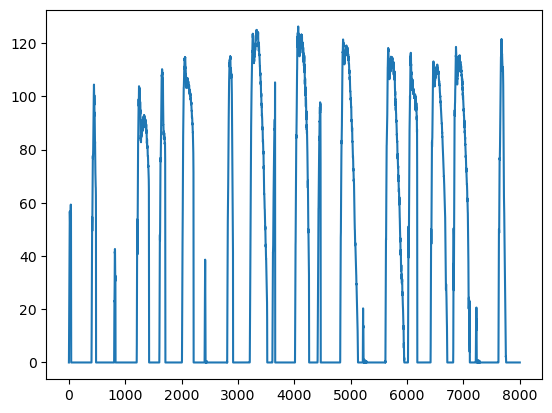

In [4]:
plt.plot(dataframe)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataframe)

In [6]:
dataset.shape

(8000, 1)

In [7]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
test.shape

(1600, 1)

In [8]:
train.shape

(6400, 1)

In [9]:
def to_sequences(dataset, time_window,output):
    x = []
    y = []

    for i in range(len(dataset)-time_window-1-output):
        #print(i)
        window = dataset[i:(i+time_window), 0]
        x.append(window)
        y.append(dataset[i+time_window:i+time_window+output, 0])

    return np.array(x),np.array(y)

In [10]:
time_window = 10
output=20

trainX, trainY = to_sequences(train, time_window, output)
testX, testY = to_sequences(test, time_window,output)

In [11]:
trainY.shape

(6369, 20)

In [12]:
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
print(trainX.shape)
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))
print(testX.shape)
trainY = trainY.reshape((trainY.shape[0], trainY.shape[1], 1))
print(trainY.shape)
testY= testY.reshape((testY.shape[0], testY.shape[1], 1))
print(testY.shape)

(6369, 10, 1)
(1569, 10, 1)
(6369, 20, 1)
(1569, 20, 1)


In [13]:
trainY.shape

(6369, 20, 1)

In [14]:
class _CRUCell(keras.layers.Layer):

    def __init__(self, in_dim, hid_dim, bias=True):
        super(_CRUCell, self).__init__()

        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.bias = bias


        self.wx_t = Dense(units=self.hid_dim*3,bias_initializer='zeros')
        self.wx_s = Dense(units= self.hid_dim*3,bias_initializer='zeros')
        self.wx_r = Dense(units=self.hid_dim, bias_initializer='zeros')


        self.wh_t = Dense(self.hid_dim*3,bias_initializer='zeros')
        self.wh_s = Dense(self.hid_dim*3,bias_initializer='zeros')
        self.wh_r = Dense(self.hid_dim, bias_initializer='zeros')

        self.reset_parameters()

    def call(self, x, hid_state = None):

        lamda = 0.5
        # print(x.shape)
        x_t, x_s, x_r = self.ts_decompose(x)

        if hid_state is None:
          hid_state = tf.zeros(3, x.shape[1], self.hid_dim)

        x_t = self.wx_t(x_t)
        x_s = self.wx_s(x_s)
        x_r = self.wx_r(x_r)

        h_t = self.wh_t(hid_state[0,:,:])
        h_s = self.wh_s(hid_state[1,:,:])

        x_autocor_t, x_cor_t, x_new_t = tf.split(x_t, num_or_size_splits=3, axis=1)
        x_autocor_s, x_cor_s, x_new_s = tf.split(x_s, num_or_size_splits=3, axis=1)
        h_autocor_t, h_cor_t, h_new_t = tf.split(h_t, num_or_size_splits=3, axis=1)
        h_autocor_s, h_cor_s, h_new_s = tf.split(h_s, num_or_size_splits=3, axis=1)

        autocor_t = tf.sigmoid(x_autocor_t + h_autocor_t)
        autocor_s = tf.sigmoid(x_autocor_s + h_autocor_s)

        cor_t = tf.sigmoid(x_cor_t + h_cor_s)
        cor_s = tf.sigmoid(x_cor_s + h_cor_t)

        new_t = lamda*tf.tanh(x_new_t + (autocor_t * h_new_t)) + (1-lamda)*tf.tanh(x_new_t + (cor_t * h_new_s))
        new_s = lamda*tf.tanh(x_new_s + (autocor_s * h_new_s)) + (1-lamda)*tf.tanh(x_new_s + (cor_s * h_new_t))

        new_state = tf.concat([tf.expand_dims(new_t, axis=0),
                       tf.expand_dims(new_s, axis=0),
                       tf.expand_dims(tf.tanh(x_r), axis=0)], axis=0)


        hid_state = tf.tensor_scatter_nd_update(hid_state, [[0], [1], [2]], new_state)

        return hid_state

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hid_dim)
        for w in self.trainable_variables:
            w.assign(tf.random.uniform(shape=w.shape, minval=-std, maxval=std))

    def ts_decompose(self, x):

        x = pd.DataFrame(x.numpy())
        dates = pd.date_range('1990-01-01', periods = len(x), freq='H')
        x.index = dates
        trend = []
        seasonal = []
        resid = []
        for i in range(len(x.columns)):
            stl = STL(x[i])
            res = stl.fit()
            trend.append(res.trend.values)
            seasonal.append(res.seasonal.values)
            resid.append(res.resid.values)

        trend = np.array(trend)
        seasonal = np.array(seasonal)
        resid = np.array(resid)

        trend = tf.transpose(tf.convert_to_tensor(trend), perm=[1, 0])
        seasonal = tf.transpose(tf.convert_to_tensor(seasonal), perm=[1, 0])
        resid = tf.transpose(tf.convert_to_tensor(resid), perm=[1, 0])

        return trend, seasonal, resid

In [15]:
class _CRU(keras.layers.Layer):

    def __init__(self, in_dim, hid_dim, out_dim, num_layers, bias = True):
        super(_CRU, self).__init__()

        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.num_layers = num_layers

        self.bias = bias
        self.out_dim = out_dim


        self.fc= keras.Sequential()
        self.fc.add(Dense(self.out_dim))
        


    def build(self,input_shape):

        self.cell_list = []
        self.cell_list.append(_CRUCell(in_dim=self.in_dim, hid_dim=self.hid_dim, bias=self.bias))

        for l in range(1, self.num_layers):
            self.cell_list.append(_CRUCell(in_dim=self.in_dim, hid_dim=self.hid_dim, bias=self.bias))

    def call(self, input, hid_state=None):

        if hid_state is None:
            hid_state = tf.zeros((self.num_layers, 3, input.shape[0] ,self.hid_dim), dtype=tf.float32)

        outs = []

        hidden = list()
        for layer in range(self.num_layers):
          # print(layer)
          hidden.append(hid_state[layer,:, :, :])

        for t in range(input.shape[1]):

            for layer in range(self.num_layers):

                if layer == 0:
                    hid_layer = self.cell_list[layer](input[:, t, :], hidden[layer])
                    # print( hidden[layer].shape)
                else:
                    input_hidden = tf.reduce_sum(hidden[layer - 1],axis=0)
                    # print(hidden[layer].shape)
                    hid_layer = self.cell_list[layer](input_hidden,hidden[layer])

                hidden[layer] = hid_layer

            outs.append(hid_layer)

        feature = tf.reduce_mean(outs[-1],axis=1)
        out = tf.reduce_sum(outs[-1],axis=0)

        out = self.fc(out)

        return out, feature

In [16]:
data_name = 'output2.csv'
time_window = 10

hid_dim = 100
out_dim = 20
num_layers = 1
epoch = 1000

In [17]:
m  = _CRU(time_window, hid_dim, out_dim, num_layers)

crit = tf.keras.losses.MeanSquaredError()

optimizer = tf.keras.optimizers.Adam(0.001)

for e in range(epoch):
    with tf.GradientTape() as tape:
        trainPredict, _ = m(trainX)
        loss = crit(trainPredict, trainY)
    gradients = tape.gradient(loss, m.trainable_variables)
    optimizer.apply_gradients(zip(gradients, m.trainable_variables))

    if (e+1) % 100 == 0:
        print("Starting epoch : ", e+1)

        testPredict,_ = m(testX)
        traindata = trainY.reshape(trainY.shape[0],trainY.shape[1])
        testdata = testY.reshape(testY.shape[0],testY.shape[1])

        testPredict = scaler.inverse_transform(testPredict.numpy().reshape(testPredict.shape[0],testPredict.shape[1]))
        trainPredict = scaler.inverse_transform(trainPredict.numpy().reshape(trainPredict.shape[0],trainPredict.shape[1]))
        testdata = scaler.inverse_transform(testdata)
        traindata = scaler.inverse_transform(traindata)

        test_rmse =  math.sqrt(mse(testPredict, testdata))
        train_rmse = math.sqrt(mse(trainPredict, traindata))

        print('[Epoch: {}/{}] [Train RMSE: {}] [Test RMSE: {}]'.format(
            e+1, epoch, str(train_rmse)[:6], str(test_rmse)[:6]))

C:\Users\PLEXTEK\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py:357: UserWarning: `build()` was called on layer '_cru_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Starting epoch :  100
[Epoch: 100/1000] [Train RMSE: 12.212] [Test RMSE: 10.813]
Starting epoch :  200
[Epoch: 200/1000] [Train RMSE: 7.5190] [Test RMSE: 6.1388]
Starting epoch :  300
[Epoch: 300/1000] [Train RMSE: 6.5590] [Test RMSE: 5.1164]
Starting epoch :  400
[Epoch: 400/1000] [Train RMSE: 6.3811] [Test RMSE: 4.8787]
Starting epoch :  500
[Epoch: 500/1000] [Train RMSE: 6.2792] [Test RMSE: 4.7201]
Starting epoch :  600
[Epoch: 600/1000] [Train RMSE: 6.2140] [Test RMSE: 4.5053]
Starting epoch :  700
[Epoch: 700/1000] [Train RMSE: 6.4072] [Test RMSE: 5.2876]
Starting epoch :  800
[Epoch: 800/1000] [Train RMSE: 6.1403] [Test RMSE: 4.3880]
Starting epoch :  900
[Epoch: 900/1000] [Train RMSE: 6.0529] [Test RMSE: 4.4030]
Starting epoch :  1000
[Epoch: 1000/1000] [Train RMSE: 5.9894] [Test RMSE: 4.4112]


In [18]:
trainX.shape

(6369, 10, 1)

In [19]:
traindata[:3]

array([[35.73 , 40.792, 42.312, 46.647, 49.429, 52.68 , 56.724, 55.462,
        55.672, 54.54 , 52.421, 51.208, 50.691, 51.483, 52.988, 52.567,
        53.829, 55.543, 54.524, 56.077],
       [40.792, 42.312, 46.647, 49.429, 52.68 , 56.724, 55.462, 55.672,
        54.54 , 52.421, 51.208, 50.691, 51.483, 52.988, 52.567, 53.829,
        55.543, 54.524, 56.077, 57.71 ],
       [42.312, 46.647, 49.429, 52.68 , 56.724, 55.462, 55.672, 54.54 ,
        52.421, 51.208, 50.691, 51.483, 52.988, 52.567, 53.829, 55.543,
        54.524, 56.077, 57.71 , 57.84 ]], dtype=float32)

In [20]:
trainPredict[:3]

array([[ 40.32143 ,  52.696903,  62.122555,  73.18376 ,  82.25711 ,
         90.71481 , 100.33049 , 105.50768 , 115.414024, 120.601875,
        124.459946, 129.61855 , 132.40663 , 135.84021 , 138.7528  ,
        141.8179  , 146.20242 , 146.1959  , 145.5478  , 145.99187 ],
       [ 44.629833,  55.20536 ,  63.436573,  73.59887 ,  81.274315,
         88.76098 ,  97.2123  , 102.042656, 110.92055 , 115.76953 ,
        119.38853 , 124.31433 , 127.04549 , 130.51245 , 133.76944 ,
        137.24336 , 141.54222 , 142.56331 , 142.67722 , 144.4823  ],
       [ 48.5984  ,  57.23847 ,  64.09715 ,  73.13154 ,  80.01866 ,
         86.24626 ,  93.67128 ,  97.92871 , 105.63542 , 109.92996 ,
        113.6672  , 118.26372 , 120.933334, 124.823746, 128.1567  ,
        131.78546 , 136.55164 , 138.56985 , 139.37738 , 142.10866 ]],
      dtype=float32)

In [21]:
dataset = scaler.inverse_transform(dataset)

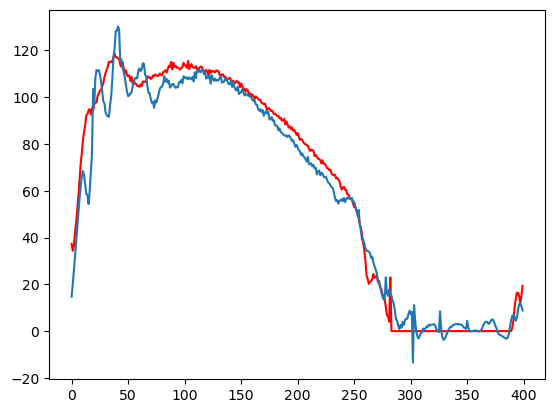

In [48]:
# plt.plot(dataset)
plt.plot(testdata[400:800,19],color='r')
plt.plot(testPredict[400:800,19])

In [23]:
from sklearn.metrics import mean_squared_error

In [24]:
import math

In [25]:
math.sqrt(mean_squared_error(traindata,trainPredict))

5.989458360335709

In [26]:
math.sqrt(mean_squared_error(testdata,testPredict))

4.411204913658309

In [27]:
x_test = np.array([0.067932,0.23938,3.3028,5.7289,13.299,19.154,23.278,29.618,32.772,34.746,37.956,40.115,42.354,45.664,47.135])
x_test = x_test.reshape((-1, 5,1))
print(x_test.shape)

(3, 5, 1)


In [28]:
yhat,_ = m(x_test)

In [29]:
yhat

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.849109 ,  1.423271 ,  3.2707624,  2.8893487,  3.0975304,
         4.649136 ,  4.29023  ,  6.1751676,  5.33017  ,  6.6640396,
         9.002652 ,  7.4573746,  8.392064 ,  9.366666 , 10.40656  ,
         9.279415 ,  5.7807417,  7.0192394,  9.985255 ,  9.475005 ],
       [ 4.651812 ,  3.3237078,  6.32226  ,  5.1705804,  3.3704953,
         4.1774735,  2.0590026,  3.5700161,  2.3193793,  3.7038279,
         5.6586018,  3.0634997,  5.115701 ,  4.363452 ,  7.453261 ,
         6.141185 ,  2.8019185,  4.397748 ,  5.3981833,  7.7957406],
       [ 4.737594 ,  3.3655453,  6.317572 ,  5.110095 ,  3.3318129,
         4.21277  ,  2.0193062,  3.6152387,  2.2041373,  3.6759393,
         5.666067 ,  2.9797575,  4.941979 ,  4.1459584,  7.4721093,
         6.09006  ,  2.876027 ,  4.280071 ,  5.3398676,  7.697646 ]],
      dtype=float32)>

In [30]:
def ts_decompose(x):

        x = pd.DataFrame(x)
        dates = pd.date_range('1990-01-01', periods = len(x), freq='D')
        x.index = dates
        trend = []
        seasonal = []
        resid = []
        for i in range(len(x.columns)):
            stl = STL(x[i])
            res = stl.fit()
            trend.append(res.trend.values)
            seasonal.append(res.seasonal.values)
            resid.append(res.resid.values)

        trend = np.array(trend)
        seasonal = np.array(seasonal)
        resid = np.array(resid)

        # print(trend.shape)
        trend = tf.transpose(tf.convert_to_tensor(trend), perm=[1, 0])
        seasonal = tf.transpose(tf.convert_to_tensor(seasonal), perm=[1, 0])
        resid = tf.transpose(tf.convert_to_tensor(resid), perm=[1, 0])

        return trend, seasonal, resid

In [31]:
trendPredict, seasonalPredict , residPredict = ts_decompose(trainPredict)

In [32]:
first_row_trend = trendPredict[0, :]

In [33]:
first_average_trend = np.mean(first_row_trend)

In [34]:
first_average_trend

92.6208838028509

In [35]:
traindata[0,:]

array([35.73 , 40.792, 42.312, 46.647, 49.429, 52.68 , 56.724, 55.462,
       55.672, 54.54 , 52.421, 51.208, 50.691, 51.483, 52.988, 52.567,
       53.829, 55.543, 54.524, 56.077], dtype=float32)

In [36]:
second_row_trend = trendPredict[1, :]

In [37]:
second_average_trend = np.mean(second_row_trend)

In [38]:
second_average_trend

92.01428917814114

In [39]:
traindata[1,:]

array([40.792, 42.312, 46.647, 49.429, 52.68 , 56.724, 55.462, 55.672,
       54.54 , 52.421, 51.208, 50.691, 51.483, 52.988, 52.567, 53.829,
       55.543, 54.524, 56.077, 57.71 ], dtype=float32)

In [40]:
third_row_trend = trendPredict[2, :]

In [41]:
third_average_trend = np.mean(third_row_trend)

In [42]:
third_average_trend

91.34216558539315

In [43]:
traindata[2,:]

array([42.312, 46.647, 49.429, 52.68 , 56.724, 55.462, 55.672, 54.54 ,
       52.421, 51.208, 50.691, 51.483, 52.988, 52.567, 53.829, 55.543,
       54.524, 56.077, 57.71 , 57.84 ], dtype=float32)